In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import pandasql as ps

In [4]:
# reading the datasets from the directory Datasets/SocioEconomic
# read the pop_stab dataframe up to 214 rows only
pop_stab =  pd.read_csv('../Datasets/SocioEconomic/political_stability_1996_2021.csv', nrows=214)
china_hdi_le =  pd.read_csv('../Datasets/SocioEconomic/China_HDI_LE1990_2021.csv')
s_korea_hdi_le = pd.read_csv('../Datasets/SocioEconomic/SKorea_HDI_LE_1990_2021.csv')
us_hdi_le =  pd.read_csv('../Datasets/SocioEconomic/US_HDI_LE_1990_2021.csv')
pop =  pd.read_csv('../Datasets/SocioEconomic/population_1960_2021.csv')
urban_pop =  pd.read_csv('../Datasets/SocioEconomic/Urban_pop_WorldBank_1960_2021.csv', skiprows=4)
gdp =  pd.read_csv('../Datasets/SocioEconomic/GDP_1960_2021.csv')
oil_prices = pd.read_csv('../Datasets/SocioEconomic/crude_oil_price_1983_2023.csv')
inflation =  pd.read_csv('../Datasets/SocioEconomic/Inflation_data_1970_2022.csv', encoding='ISO-8859-1')
co2_emission = pd.read_csv('../Datasets/SocioEconomic/co2_emission_2021.csv')

## Cleaning Datasets
### Political Stability

The dataset under consideration contains information about the "Political Stability and Absence of Violence/Terrorism" index for various countries from the year 1996 to 2021. The index, coded as 'PV.EST', is measured on a scale from -2.5 to 2.5, with a higher value indicating more stable political conditions and less violence or terrorism. A lower score indicates a less stable political environment and higher levels of violence or terrorism.

The dataset includes 214 countries. However, for the purpose of our analysis, we will focus on three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the data to include only these countries.

- **Renaming columns**: The year columns are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

- **Handling missing years**: Our dataset does not include data for the years 1997, 1999, and 2001. We handle this by computing the missing values as the average of the previous and following years. This is done under the assumption that the political stability index changes smoothly over time.

- **Sorting columns**: After inserting the missing years, we sort our columns to maintain a chronological order of years.



In [5]:
# defining a list of countries
countries_of_interest = ['USA', 'CHN', 'KOR']
# get all the rows for each country of interest
pop_stab = pop_stab[pop_stab['Country Code'].isin(countries_of_interest)]
# renaming the columns by removing [YR]
pop_stab = pop_stab.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop_stab.columns[4:]})
# Change the type of year columns to float
for col in pop_stab.columns[4:]:
    pop_stab[col] = pop_stab[col].astype(float)

In [6]:
pop_stab.columns

Index(['Country Name', 'Country Code', 'Series Name', 'Series Code', '1996',
       '1998', '2000', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021'],
      dtype='object')

In [7]:
# As you can see above, certain years are missing from the columns
missing_years = [1997, 1999, 2001]

In [8]:
def insert_missing_years(df, missing_years):
    for year in missing_years:
        prev_year = str(year - 1)
        next_year = str(year + 1)

        # Check if previous and next year columns exist
        if prev_year in df.columns and next_year in df.columns:
            df[prev_year] = pd.to_numeric(df[prev_year], errors='coerce')
            df[next_year] = pd.to_numeric(df[next_year], errors='coerce')
            df[str(year)] = (df[prev_year] + df[next_year]) / 2
        else:
            print(f"Cannot compute for year {year}, adjacent years data are not available.")
        
    # Sort the columns
    non_year_cols = ["Country Name", "Country Code", "Series Name", "Series Code"]
    year_cols = [str(i) for i in sorted(int(col) for col in df.columns if col.isdigit())]
    cols = non_year_cols + year_cols
    
    return df.reindex(columns=cols)

pop_stab = insert_missing_years(pop_stab, missing_years)

In [9]:
pop_stab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 40 to 203
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  3 non-null      object 
 1   Country Code  3 non-null      object 
 2   Series Name   3 non-null      object 
 3   Series Code   3 non-null      object 
 4   1996          3 non-null      float64
 5   1997          3 non-null      float64
 6   1998          3 non-null      float64
 7   1999          3 non-null      float64
 8   2000          3 non-null      float64
 9   2001          3 non-null      float64
 10  2002          3 non-null      float64
 11  2003          3 non-null      float64
 12  2004          3 non-null      float64
 13  2005          3 non-null      float64
 14  2006          3 non-null      float64
 15  2007          3 non-null      float64
 16  2008          3 non-null      float64
 17  2009          3 non-null      float64
 18  2010          3 non-null      f

In [10]:
pop_stab.head()

,Country Name,Country Code,Series Name,Series Code,1996,1997,1998,1999,2000,2001,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
40,China,CHN,Political Stability and Absence of Violence/Te...,PV.EST,-0.097849,-0.245977,-0.394105,-0.302011,-0.209917,-0.268772,...,-0.538782,-0.543790,-0.522584,-0.550295,-0.499395,-0.231018,-0.300023,-0.256689,-0.329403,-0.481860
101,"Korea, Rep.",KOR,Political Stability and Absence of Violence/Te...,PV.EST,0.566771,0.540322,0.513873,0.455959,0.398045,0.319909,...,0.267103,0.278579,0.108569,0.161014,0.163469,0.385621,0.637073,0.551206,0.566344,0.662571
203,United States,USA,Political Stability and Absence of Violence/Te...,PV.EST,0.935006,0.907309,0.879613,0.981211,1.082809,0.684143,...,0.632442,0.643073,0.582420,0.678062,0.402303,0.291817,0.421418,0.134975,0.033438,0.004954


#### Population & Urban Population

##### Population
The dataset under consideration contains information about the total population of various countries from the year 1960 to 2021. For our purposes, we're interested in the population data for three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the population data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the population data to include only these countries.

- **Renaming columns**: The year columns in the population data are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Once these steps are complete, we have a clean and concise dataframe that contains the population data for each year for the three countries of interest.


In [11]:
# get all the rows for each country of interest
pop = pop[pop['Country Code'].isin(countries_of_interest)]
# renaming the columns by removing [YR]
pop = pop.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop.columns})
# Change the type of year columns to float
for col in pop.columns[4:]:
    pop[col] = pop[col].astype(float)

In [12]:
pop.head()

,Series Name,Series Code,Country Name,Country Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
41,"Population, total",SP.POP.TOTL,China,CHN,667070000.0,660330000.0,665770000.0,682335000.0,698355000.0,715185000.0,...,1.354190e+09,1.363240e+09,1.371860e+09,1.379860e+09,1.387790e+09,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09
104,"Population, total",SP.POP.TOTL,"Korea, Rep.",KOR,25012374.0,25765673.0,26513030.0,27261747.0,27984155.0,28704674.0,...,5.019985e+07,5.042889e+07,5.074666e+07,5.101495e+07,5.121780e+07,5.136191e+07,5.158506e+07,5.176482e+07,5.183624e+07,5.174488e+07
206,"Population, total",SP.POP.TOTL,United States,USA,180671000.0,183691000.0,186538000.0,189242000.0,191889000.0,194303000.0,...,3.138777e+08,3.160599e+08,3.183863e+08,3.207390e+08,3.230718e+08,3.251221e+08,3.268382e+08,3.283300e+08,3.315011e+08,3.318937e+08


##### Urban Population Data

The dataset under consideration contains information about the percentage of the total population living in urban areas for various countries from the year 1960 to 2021. For our purposes, we're interested in the urban population data for three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the urban population data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the urban population data to include only these countries.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Once these steps are complete, we have a clean and concise dataframe that contains the urban population data for each year for the three countries of interest.


In [13]:
# get all the rows for each country of interest
urban_pop = urban_pop[urban_pop['Country Code'].isin(countries_of_interest)]
# Change the type of year columns to float
for col in urban_pop.columns[4:]:
    urban_pop[col] = urban_pop[col].astype(float)

In [14]:
urban_pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
40,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,51.765,53.013,54.259,55.500,56.736,57.960,59.152,60.308,61.428,62.512
126,"Korea, Rep.",KOR,Urban population (% of total population),SP.URB.TOTL.IN.ZS,27.710,28.531,29.461,30.407,31.372,32.351,...,81.851,81.779,81.707,81.634,81.562,81.503,81.459,81.430,81.414,81.414
251,United States,USA,Urban population (% of total population),SP.URB.TOTL.IN.ZS,69.996,70.377,70.757,71.134,71.508,71.879,...,81.119,81.299,81.483,81.671,81.862,82.058,82.256,82.459,82.664,82.873


### Human Development Index and Life Expectancy

The datasets provided contain key-value pairs representing various development indicators for China, South Korea, and the United States from the years 1990 to 2021. These indicators include the Human Development Index (HDI), life expectancy at birth, Gross National Income per Capita, Mean Years of Schooling, Gender Development Index, among others.

For the purpose of our analysis, we're interested in the HDI and life expectancy at birth for each of these three countries. 

Our data cleaning and preparation steps include:

- **Extraction of relevant information**: We extract the ISO country code and country name from each dataframe.

- **Filtering relevant rows**: We filter rows related to the HDI and life expectancy at birth for different years.

- **Creating new dataframes**: We create two new dataframes for each country to hold the HDI and life expectancy data, respectively.

- **Filling the dataframes**: We iterate over the filtered rows, extracting the year and value for each entry. The year is extracted from the key by splitting the string and removing parentheses. The value for each year is added to the appropriate dataframe.

- **Concatenating the dataframes**: We then concatenate all the individual country dataframes into two large dataframes: one for the HDI data and one for the life expectancy data.



In [15]:
def process_dataframe(df):
    # get the basic information
    country_code = df.loc[df['key'] == 'ISO3', 'value'].values[0]
    country_name = df.loc[df['key'] == 'HDR Country Name', 'value'].values[0]
    # filter rows for HDI and Life Expectancy
    hdi_rows = df[df['key'].str.startswith('Human Development Index (value)')]
    life_exp_rows = df[df['key'].str.match(r'^Life Expectancy at Birth \(years\) \(\d{4}\)$')]
    # create the two empty dataframes
    hdi_df = pd.DataFrame({'Country Name': country_name, 'Country Code': country_code}, index=[0])
    life_exp_df = pd.DataFrame({'Country Name': country_name, 'Country Code': country_code}, index=[0])
    # fill the dataframes
    for index, row in hdi_rows.iterrows():
        year = row['key'].split(' ')[-1]
        year = year.replace('(', '').replace(')', '')  # remove parentheses
        hdi_df[year] = row['value']

    for index, row in life_exp_rows.iterrows():
        year = row['key'].split(' ')[-1]
        year = year.replace('(', '').replace(')', '')  # remove parentheses
        life_exp_df[year] = row['value']
    
    return hdi_df, life_exp_df


In [16]:
# List of your dataframes
hdi_le_lists = [china_hdi_le, s_korea_hdi_le, us_hdi_le]

# Apply the function to each dataframe in the list and unzip the results
hdi_dfs, life_exp_dfs = zip(*[process_dataframe(df) for df in hdi_le_lists])

# Concatenate all the resulting dataframes
hdi_df = pd.concat(hdi_dfs)
life_exp_df = pd.concat(life_exp_dfs)


In [17]:
hdi_df.head()

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,China,CHN,0.484,0.492,0.504,0.515,0.525,0.535,0.545,0.554,...,0.709,0.717,0.725,0.733,0.74,0.747,0.755,0.762,0.764,0.768
0,Korea (Republic of),KOR,.737,.747,.754,.763,.773,.783,.793,.806,...,.897,.901,.906,.909,.912,.916,.919,.923,.922,.925
0,United States,USA,.872,.873,.878,.88,.884,.885,.887,.89,...,.916,.917,.919,.92,.922,.924,.927,.93,.92,.921


In [18]:
life_exp_df

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,China,CHN,68.0052,68.1688,68.7345,69.2164,69.5201,70.008,70.2659,70.672,...,76.1923,76.4523,76.7173,76.9771,77.2177,77.2476,77.7444,77.968,78.0766,78.2107
0,Korea (Republic of),KOR,71.9401,72.4207,72.9564,73.283,73.61109999999999,73.9409,74.2757,74.97069999999999,...,81.3473,81.86369999999999,82.3781,82.5605,82.9259,83.2855,83.34269999999999,83.6557,83.60890000000001,83.6978
0,United States,USA,75.3699,75.5227,75.77760000000001,75.56699999999999,75.7377,75.8536,76.17529999999999,76.498,...,78.94410000000001,78.9507,79.0175,78.8694,78.84820000000001,78.82129999999999,78.9896,79.13800000000001,77.4144,77.1982


### Gross Domestic Product

The GDP dataset under analysis contains information about the Gross Domestic Product for various countries for a range of years. GDP is a measure of the economic output of a country.

As with the "Political Stability" and "Human Development Index and Life Expectancy" datasets, we will focus on three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the GDP data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the GDP data to include only these countries.

- **Renaming columns**: The year columns in the GDP data are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Again, it's important to visualize the data after cleaning to confirm that it's in the correct format and to identify any anomalies that might require further cleaning.


In [19]:
# get all the rows for each country of interest
gdp = gdp[gdp['Country Code'].isin(countries_of_interest)]
# renaming the columns by removing [YR]
gdp = gdp.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in gdp.columns[4:]})
# Change the type of year columns to float
for col in gdp.columns[4:]:
    gdp[col] = gdp[col].astype(float)

In [20]:
gdp.head()

,Series Name,Series Code,Country Name,Country Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
41,GDP (current US$),NY.GDP.MKTP.CD,China,CHN,5.971647e+10,5.005687e+10,4.720936e+10,5.070680e+10,5.970834e+10,7.043627e+10,...,8.532230e+12,9.570406e+12,1.047568e+13,1.106155e+13,1.123328e+13,1.231041e+13,1.389482e+13,1.427994e+13,1.468767e+13,1.773406e+13
104,GDP (current US$),NY.GDP.MKTP.CD,"Korea, Rep.",KOR,3.958824e+09,2.417638e+09,2.814626e+09,3.988477e+09,3.459033e+09,3.120871e+09,...,1.278428e+12,1.370795e+12,1.484318e+12,1.465773e+12,1.500112e+12,1.623901e+12,1.724846e+12,1.651423e+12,1.644313e+12,1.810956e+12
206,GDP (current US$),NY.GDP.MKTP.CD,United States,USA,5.433000e+11,5.633000e+11,6.051000e+11,6.386000e+11,6.858000e+11,7.437000e+11,...,1.625397e+13,1.684319e+13,1.755068e+13,1.820602e+13,1.869511e+13,1.947734e+13,2.053306e+13,2.138098e+13,2.106047e+13,2.331508e+13


### Crude Oil Prices

The dataset under consideration contains information about the crude oil prices from the year 1983 to 2023. The data includes the date of observation, the price of crude oil on that date, the percentage change in price from the previous date, and the absolute change in price from the previous date.

Our data cleaning and preparation steps for the crude oil prices data include:

- **Date conversion**: The 'date' column in the data is converted into datetime format for easier manipulation and analysis.

- **Year extraction**: A new 'year' column is created by extracting the year from the 'date' column. This allows for annual analysis of the data.

- **Calculating average annual price**: The data is then grouped by 'year', and the average price of crude oil for each year is calculated. This results in a new dataframe that shows the average price of crude oil for each year.

After these steps, we have a concise and tidy dataframe that contains the average price of crude oil for each year from 1983 to 2023.



In [21]:
# Convert the 'date' column to datetime format
oil_prices['date'] = pd.to_datetime(oil_prices['date'])

# Extract the year from the 'date' column and create a new 'year' column
oil_prices['Year'] = oil_prices['date'].dt.year

# Group the data by 'year' and calculate the average 'price'
avg_oil_price = oil_prices.groupby('Year')['price'].mean().reset_index()

# Display the average oil price data
avg_oil_price.head()

,Year,price
0,1983,30.468000
1,1984,29.240833
2,1985,27.873333
3,1986,14.413333
4,1987,19.036667


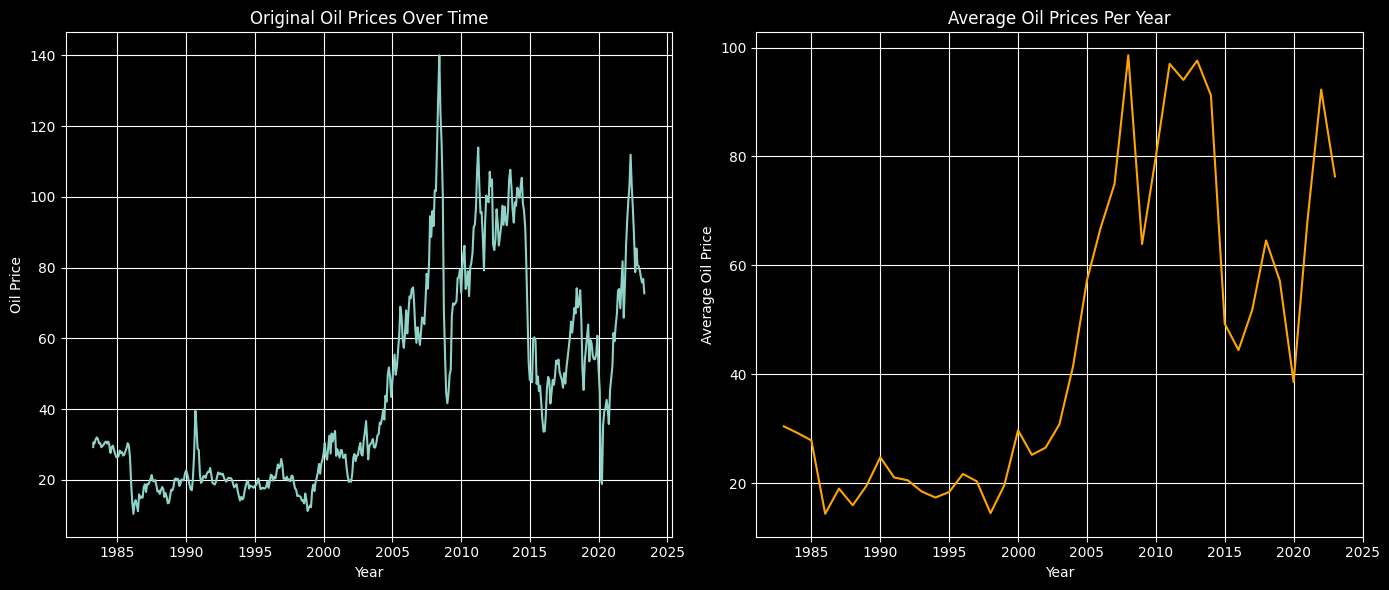

In [22]:
# Plot the original oil prices over time
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(oil_prices['date'], oil_prices['price'], label='Original Data')
plt.title('Original Oil Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Oil Price')
plt.grid(True)

# Plot the average oil prices per year
plt.subplot(1, 2, 2)
plt.plot(avg_oil_price['Year'], avg_oil_price['price'], label='Average per Year', color='orange')
plt.title('Average Oil Prices Per Year')
plt.xlabel('Year')
plt.ylabel('Average Oil Price')
plt.grid(True)

plt.tight_layout()
plt.show()

### Inflation Data

The dataset under consideration contains information about various inflation indicators for a range of countries over a number of years. For our purposes, we're interested in the "Headline Consumer Price Inflation" for three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the inflation data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the inflation data to include only these countries.

- **Indicator selection**: We're interested in the "Headline Consumer Price Inflation" indicator. We filter the data to include only this indicator.

- **Removing unnecessary columns**: We remove columns that are not relevant to our analysis.

- **Renaming columns**: We rename the 'Country' column to 'Country Name' for consistency with our other datasets.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Once these steps are complete, we have a clean and concise dataframe that contains the "Headline Consumer Price Inflation" for each year for the three countries of interest.

In [23]:
# get all the rows for each country of interest
inflation = inflation[inflation['Country Code'].isin(countries_of_interest)]
# consider only Headline Consumer Price Inflation
inflation = inflation[inflation['Series Name'] == 'Headline Consumer Price Inflation']
inflation.drop(inflation.columns[-6:], axis=1, inplace=True)
# renaming the 'Country' column to be consistent
inflation = inflation.rename(columns={'Country': 'Country Name'})
# Change the type of year columns to float
for col in inflation.columns[5:]:
    inflation[col] = inflation[col].astype(float)

### CO2 Emissions

In [24]:
# Renaming the columns for consistency
co2_emission.rename(columns={'Annual CO₂ emissions': 'co2_emission', 
                             'Code': 'Country Code',
                             'Entity': 'Country Name'}, inplace=True)

# get all the rows for each country of interest
co2_emission = co2_emission[co2_emission['Country Code'].isin(countries_of_interest)]

In [25]:
co2_emission.head()

,Country Name,Country Code,Year,co2_emission
6054,China,CHN,1899,0.0
6055,China,CHN,1902,0.0
6056,China,CHN,1903,0.0
6057,China,CHN,1904,0.0
6058,China,CHN,1905,0.0


### Melting and Combining dateframes

In [26]:
## Helper functions
def change_column_types(df, first_col, second_col):
    df[first_col] = df[first_col].astype(int)
    df[second_col] = df[second_col].astype(float)
    return df

In [27]:
# Drop unwanted columns
pop_stab = pop_stab.drop(['Series Name', 'Series Code'], axis=1)

# Melt the dataframe
pop_stab_melted = pop_stab.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Stability")
pop_stab_melted = change_column_types(pop_stab_melted, 'Year', 'Stability')
pop_stab_melted = pop_stab_melted[(pop_stab_melted['Year'] >= 1996) & (pop_stab_melted['Year'] <= 2021)]

In [28]:
# Drop unwanted columns
pop = pop.drop(['Series Name', 'Series Code'], axis=1)


# Melt the dataframe
pop_melted = pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")
pop_melted = change_column_types(pop_melted, 'Year', 'Population')
pop_melted = pop_melted[(pop_melted['Year'] >= 1996) & (pop_melted['Year'] <= 2021)]

In [29]:
# Drop unwanted columns
urban_pop = urban_pop.drop(['Indicator Name', 'Indicator Code'], axis=1)

# Melt the dataframe
urban_pop_melted = urban_pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Urban_Population")
urban_pop_melted = change_column_types(urban_pop_melted, 'Year', 'Urban_Population')
urban_pop_melted = urban_pop_melted[(urban_pop_melted['Year'] >= 1996) & (urban_pop_melted['Year'] <= 2021)]

In [30]:
# Melt the dataframe
hdi_df_melted = hdi_df.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="HDI")
hdi_df_melted = change_column_types(hdi_df_melted, 'Year', 'HDI')
hdi_df_melted = hdi_df_melted[(hdi_df_melted['Year'] >= 1996) & (hdi_df_melted['Year'] <= 2021)]

In [31]:
life_exp_df_melted  =  life_exp_df.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Life_Expectancy")
life_exp_df_melted = change_column_types(life_exp_df_melted, 'Year', 'Life_Expectancy')
life_exp_df_melted = life_exp_df_melted[(life_exp_df_melted['Year'] >= 1996) & (life_exp_df_melted['Year'] <= 2021)]

In [32]:
# Drop unwanted columns
gdp = gdp.drop(['Series Name', 'Series Code'], axis=1)
gdp_melted  =  gdp.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP")
gdp_melted = change_column_types(gdp_melted, 'Year', 'GDP')
gdp_melted = gdp_melted[(gdp_melted['Year'] >= 1996) & (gdp_melted['Year'] <= 2021)]

In [33]:
# Drop unwanted columns
inflation = inflation.drop(['IMF Country Code', 'Series Name', 'Indicator Type'], axis=1)
inflation_melted  =  inflation.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Inflation")
inflation_melted = change_column_types(inflation_melted, 'Year', 'Inflation')
inflation_melted = inflation_melted[(inflation_melted['Year'] >= 1996) & (inflation_melted['Year'] <= 2021)]

In [34]:
avg_oil_price_melted = change_column_types(avg_oil_price, 'Year', 'price')
avg_oil_price_melted = avg_oil_price_melted[(avg_oil_price_melted['Year']>=1996) & (avg_oil_price_melted['Year']<=2021)]

In [35]:
# Filtering the co2_emission dataframe for the years 1996 to 2021
co2_emission = co2_emission[(co2_emission['Year'] >= 1996) & (co2_emission['Year'] <= 2021)]

In [37]:
query = """
SELECT A.'Country Name' as 'Country Name', A.'Country Code', A.Year, A.Stability, B.Inflation, 
        C.Population, D.Urban_Population, E.HDI, F.Life_Expectancy, G.GDP, H.co2_emission
FROM pop_stab_melted AS A
INNER JOIN inflation_melted AS B ON A.'Country Code' = B.'Country Code' AND A.Year = B.Year
INNER JOIN pop_melted AS C ON A.'Country Code' = C.'Country Code' AND A.Year = C.Year
INNER JOIN urban_pop_melted AS D ON A.'Country Code' = D.'Country Code' AND A.Year = D.Year
INNER JOIN hdi_df_melted AS E ON A.'Country Code' = E.'Country Code' AND A.Year = E.Year
INNER JOIN life_exp_df_melted AS F ON A.'Country Code' = F.'Country Code' AND A.Year = F.Year
INNER JOIN gdp_melted AS G ON A.'Country Code' = G.'Country Code' AND A.Year = G.Year
INNER JOIN co2_emission AS H ON A.'Country Code' = H.'Country Code' AND A.Year = H.Year
"""

merged_df = ps.sqldf(query, locals())

In [38]:
merged_df.head()

,Country Name,Country Code,Year,Stability,Inflation,Population,Urban_Population,HDI,Life_Expectancy,GDP,co2_emission
0,China,CHN,1996,-0.097849,8.31,1.217550e+09,31.916,0.545,70.2659,8.637467e+11,3.503234e+09
1,"Korea, Rep.",KOR,1996,0.566771,4.92,4.552468e+07,78.662,0.793,74.2757,6.101696e+11,4.210583e+08
2,United States,USA,1996,0.935006,2.93,2.693940e+08,77.636,0.887,76.1753,8.073122e+12,5.616431e+09
3,China,CHN,1997,-0.245977,2.79,1.230075e+09,32.883,0.554,70.6720,9.616040e+11,3.510169e+09
4,"Korea, Rep.",KOR,1997,0.540322,4.44,4.595358e+07,78.905,0.806,74.9707,5.697545e+11,4.449896e+08


In [39]:
china_df = merged_df[merged_df['Country Code'] == 'CHN']
korea_df = merged_df[merged_df['Country Code'] == 'KOR']
usa_df = merged_df[merged_df['Country Code'] == 'USA']

In [40]:
china_df.tail()

,Country Name,Country Code,Year,Stability,Inflation,Population,Urban_Population,HDI,Life_Expectancy,GDP,co2_emission
63,China,CHN,2017,-0.231018,1.56,1.396215e+09,57.960,0.747,77.2476,1.231041e+13,1.001111e+10
66,China,CHN,2018,-0.300023,2.07,1.402760e+09,59.152,0.755,77.7444,1.389482e+13,1.035388e+10
69,China,CHN,2019,-0.256689,2.90,1.407745e+09,60.308,0.762,77.9680,1.427994e+13,1.074100e+10
72,China,CHN,2020,-0.329403,2.42,1.411100e+09,61.428,0.764,78.0766,1.468767e+13,1.095621e+10
75,China,CHN,2021,-0.481860,0.90,1.412360e+09,62.512,0.768,78.2107,1.773406e+13,1.147237e+10
